### Churn prediction project

#### Data preparation

In [3]:
# Import the necessary dependency
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [5]:
# Load the data
df = pd.read_csv(url)

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
trans  = df.head().T

In [16]:
categorical_columns = list(df.dtypes[df.dtypes == object].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")

In [19]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [21]:
# The totalcharges column has a dtype of object when it is actually numeric lets convert it to numerical data
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [22]:
df.totalcharges = df.totalcharges.fillna(0)

In [23]:
df.churn.head()

0     no
1     no
2    yes
3     no
4    yes
Name: churn, dtype: object

In [24]:
df.churn = (df.churn == 'yes').astype(int)

#### Setting up the validation framework

In [26]:
from sklearn.model_selection import train_test_split

In [29]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [30]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [31]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [33]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

#### EDA

- Check missing values
- Look at the target variable (churn)
- Look at numerical and categorical variables

In [38]:
# reset the index
df_full_train = df_full_train.reset_index(drop=True)

In [39]:
# check for missing values
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [44]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [48]:
# same as the porportion of the positive churn because the values contains just 0, 1
global_churn_rate = df_full_train.churn.mean()

round(global_churn_rate, 2)

0.27

In [50]:
numericals = ["tenure", "monthlycharges", "totalcharges"]


In [57]:
categorical_columns.append('seniorcitizen')
df_full_train[categorical_columns].nunique()

gender                 2
partner                2
dependents             2
phoneservice           2
multiplelines          3
internetservice        3
onlinesecurity         3
onlinebackup           3
deviceprotection       3
techsupport            3
streamingtv            3
streamingmovies        3
contract               3
paperlessbilling       2
paymentmethod          4
totalcharges        5291
churn                  2
seniorcitizen          2
dtype: int64

#### Feature importance: Churn rate and risk ratio

In [58]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_female

0.27682403433476394

In [71]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male


0.2632135306553911

In [70]:
global_churn = df_full_train.churn.mean()
global_churn

0.26996805111821087

In [72]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [73]:
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_partner

0.20503330866025166

In [75]:
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
churn_no_partner

0.3298090040927694

#### Risk ratio

In [76]:
churn_no_partner / global_churn

1.2216593879412643

In [77]:
churn_partner / global_churn

0.7594724924338315

In [78]:
from IPython.display import display

In [81]:
for c in categorical_columns:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


totalcharges


,mean,count,diff,risk
totalcharges,,,,
0.00,0.0,8,-0.269968,0.000000
18.80,0.0,1,-0.269968,0.000000
18.85,0.5,2,0.230032,1.852071
18.90,0.0,1,-0.269968,0.000000
19.00,0.0,1,-0.269968,0.000000
...,...,...,...,...
8547.15,0.0,1,-0.269968,0.000000
8564.75,0.0,1,-0.269968,0.000000
8594.40,0.0,1,-0.269968,0.000000


churn


,mean,count,diff,risk
churn,,,,
0,0.0,4113,-0.269968,0.000000
1,1.0,1521,0.730032,3.704142


seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


#### Feature importance: Mutual information

In [82]:
from sklearn.metrics import mutual_info_score

In [83]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [84]:
mutual_info_score(df_full_train.gender, df_full_train.churn)

0.0001174846211139946

In [85]:
mutual_info_score(df_full_train.partner, df_full_train.churn)

0.009967689095399745

In [88]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [89]:
mi = df_full_train[categorical_columns].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

c:\Users\oluwa\.conda\envs\ml-zoomcamp\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


churn               0.583227
totalcharges        0.547955
contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

#### Feature importance: Correlation

In [90]:
df_full_train[numericals].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [92]:
# to check the importance not the direction use .abs
df_full_train[numericals].corrwith(df_full_train.churn).abs()

tenure            0.351885
monthlycharges    0.196805
totalcharges      0.196353
dtype: float64

 #### One-hot encoding

In [93]:
from sklearn.feature_extraction import DictVectorizer

In [96]:
categorical_columns.remove("churn")

In [98]:
dv = DictVectorizer(sparse=False)

# get_feature_names()

train_dict = df_train[categorical_columns + numericals].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numericals].to_dict(orient='records')
X_val = dv.transform(val_dict)

C:\Users\oluwa\AppData\Local\Temp\ipykernel_10176\2331923478.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  train_dict = df_train[categorical_columns + numericals].to_dict(orient='records')
C:\Users\oluwa\AppData\Local\Temp\ipykernel_10176\2331923478.py:8: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  val_dict = df_val[categorical_columns + numericals].to_dict(orient='records')


#### Logistic regression

In [100]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [101]:
z = np.linspace(-7, 7, 51)

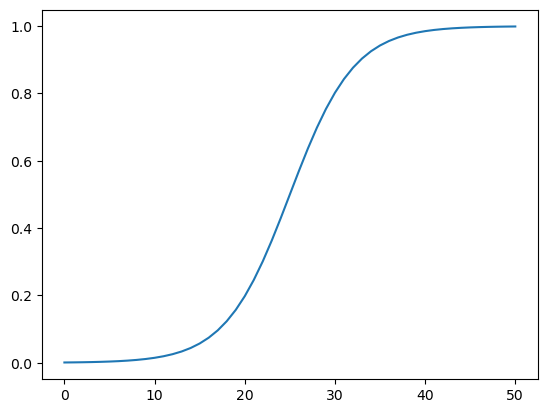

In [108]:
plt.plot(sigmoid(z));

In [109]:
def linear_regression(xi):
    result = w0
    
    for j in range(len(w)):
        result = result + xi[j] * w[j]
        
    return result

In [110]:
def logistic_regression(xi):
    score = w0
    
    for j in range(len(w)):
        score = score + xi[j] * w[j]
        
    result = sigmoid(score)
    return result

#### Training logistic regression with Scikit-Learn

In [111]:
from sklearn.linear_model import LogisticRegression

In [126]:
model = LogisticRegression(max_iter=2000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [113]:
model.intercept_[0]

-0.10903314581496253

In [116]:
model.coef_[0][1]

-0.17488045967805127

In [127]:
model.n_iter_

array([1930])

In [128]:
y_pred = model.predict_proba(X_val)[:, 1]

In [129]:
churn_decision = (y_pred >= 0.5)

In [130]:
(y_val == churn_decision).mean()

0.8034066713981547

In [131]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [132]:
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [133]:
df_pred.correct.mean()

0.8034066713981547

In [136]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

#### Model interpretation

In [168]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.971,
 'contract=one_year': -0.024,
 'contract=two_year': -0.948,
 'dependents=no': 0.027,
 'dependents=yes': -0.036}

In [149]:
small = ['contract', 'tenure', 'monthlycharges']

In [151]:
dict_train_small = df_train[small].to_dict(orient='records')
dict_val_small = df_val[small].to_dict(orient='records')

In [155]:
dv_small = DictVectorizer(sparse=False)

dv_small.fit(dict_train_small)

DictVectorizer(sparse=False)

In [153]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [156]:
X_train_small = dv_small.transform(dict_train_small)

In [158]:
model_small = LogisticRegression()

model_small.fit(X_train_small, y_train)

LogisticRegression()

In [171]:
w0 = model_small.intercept_[0]
w0

-2.4779575963120264

In [164]:
w = model_small.coef_[0]

In [170]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': 0.971,
 'contract=one_year': -0.024,
 'contract=two_year': -0.948,
 'monthlycharges': 0.027,
 'tenure': -0.036}

#### Using the model

In [173]:
dicts_full_train = df_full_train[categorical_columns + numericals].to_dict(orient='records')

C:\Users\oluwa\AppData\Local\Temp\ipykernel_10176\3775731116.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dicts_full_train = df_full_train[categorical_columns + numericals].to_dict(orient='records')


In [174]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [178]:
y_full_train = df_full_train.churn.values

In [179]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_full_train, y_full_train)

c:\Users\oluwa\.conda\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [180]:
dicts_test = df_test[categorical_columns + numericals].to_dict(orient='records')

C:\Users\oluwa\AppData\Local\Temp\ipykernel_10176\4194381545.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dicts_test = df_test[categorical_columns + numericals].to_dict(orient='records')


In [181]:
X_test = dv.transform(dicts_test)

In [185]:
y_pred = model.predict_proba(X_test)[:, 1]

In [188]:
churn_decision = (y_pred >= 0.5)

In [189]:
(y_test == churn_decision).mean()

0.8147622427253371